In [76]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [77]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [78]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [79]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [80]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)



In [81]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [82]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [83]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [84]:

#Find columns in the data set "measurement"
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [85]:
# Find the most recent date in the data set.

# most_recent_date = session.query(func.max(Measurement.date)).scalar()

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


In [86]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

print(f"Most recent date: {most_recent_date}")
print(f"A year ago is: {year_ago.strftime('%Y-%m-%d')}")


Most recent date: 2017-08-23
A year ago is: 2016-08-23


In [87]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp ).filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()
dates = [result[0] for result in results]
precipitation = [result[1] for result in results]

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')
precipitation_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


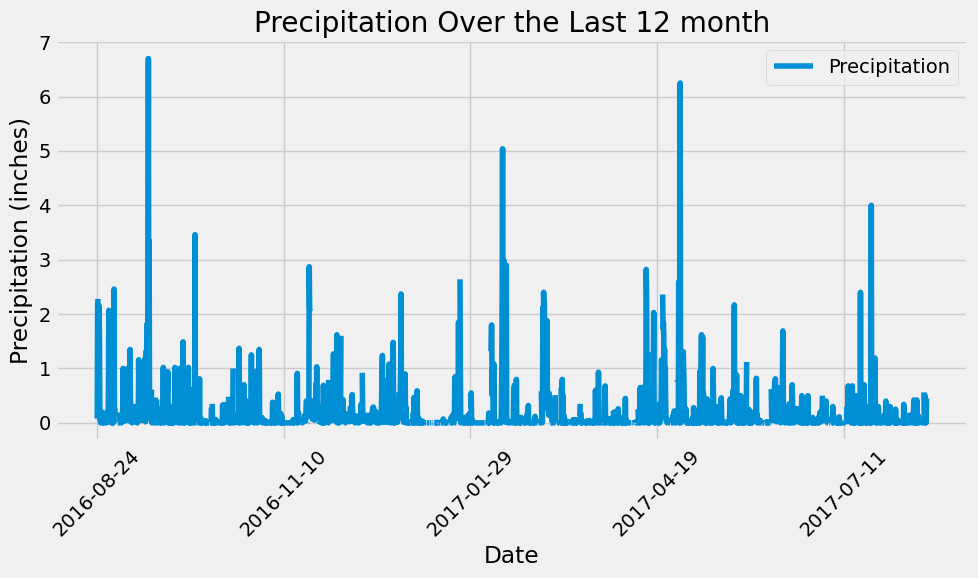

In [88]:
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(x='Date', y ='Precipitation', kind='line', figsize=(10, 6))
plt.title("Precipitation Over the Last 12 month")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [89]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()
print(f"Summary statistics for precipitation: \n{summary_stats}")


Summary statistics for precipitation: 
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


In [90]:
#Find columns in the data set "station"
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Station Analysis

In [91]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.id).distinct().count()

print(f"Number of stations is: {station_count}")

Number of stations is: 9


In [92]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
#List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


for station, count in most_active_stations:
    print(f"Station: {station}, Observations: {count}")



Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [93]:
#Most active station
most_active_station = most_active_stations[0][0]
most_active_station

'USC00519281'

In [94]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#You’ll need to use functions such as func.min, func.max, and func.avg in your query.
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station)
min_temp, max_temp, avg_temp = temperature_stats[0]

print(f"Stats for the station number {most_active_station}")
print(f"Lowest temperature is: {min_temp}")
print(f"Highest temperature is: {max_temp}")
print(f"Average temperature is: {avg_temp}")

Stats for the station number USC00519281
Lowest temperature is: 54.0
Highest temperature is: 85.0
Average temperature is: 71.66378066378067


In [95]:
# Using the most active station id find temperature for the last 12 month
temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
        filter(Measurement.date >= year_ago)

In [96]:
#Create empty list for temperatures
temperatures = []
for temp in temp_data:
    temperatures.append(temp[1])
    print(temp)

('2016-08-24', 77.0)
('2016-08-25', 80.0)
('2016-08-26', 80.0)
('2016-08-27', 75.0)
('2016-08-28', 73.0)
('2016-08-29', 78.0)
('2016-08-30', 77.0)
('2016-08-31', 78.0)
('2016-09-01', 80.0)
('2016-09-02', 80.0)
('2016-09-03', 78.0)
('2016-09-04', 78.0)
('2016-09-05', 78.0)
('2016-09-06', 73.0)
('2016-09-07', 74.0)
('2016-09-08', 80.0)
('2016-09-09', 79.0)
('2016-09-10', 77.0)
('2016-09-11', 80.0)
('2016-09-12', 76.0)
('2016-09-13', 79.0)
('2016-09-14', 75.0)
('2016-09-15', 79.0)
('2016-09-16', 78.0)
('2016-09-17', 79.0)
('2016-09-18', 78.0)
('2016-09-19', 78.0)
('2016-09-20', 76.0)
('2016-09-21', 74.0)
('2016-09-22', 77.0)
('2016-09-23', 78.0)
('2016-09-24', 79.0)
('2016-09-25', 79.0)
('2016-09-26', 77.0)
('2016-09-27', 80.0)
('2016-09-28', 78.0)
('2016-09-29', 78.0)
('2016-09-30', 78.0)
('2016-10-01', 77.0)
('2016-10-02', 79.0)
('2016-10-03', 79.0)
('2016-10-04', 79.0)
('2016-10-05', 79.0)
('2016-10-06', 75.0)
('2016-10-07', 76.0)
('2016-10-08', 73.0)
('2016-10-09', 72.0)
('2016-10-10'

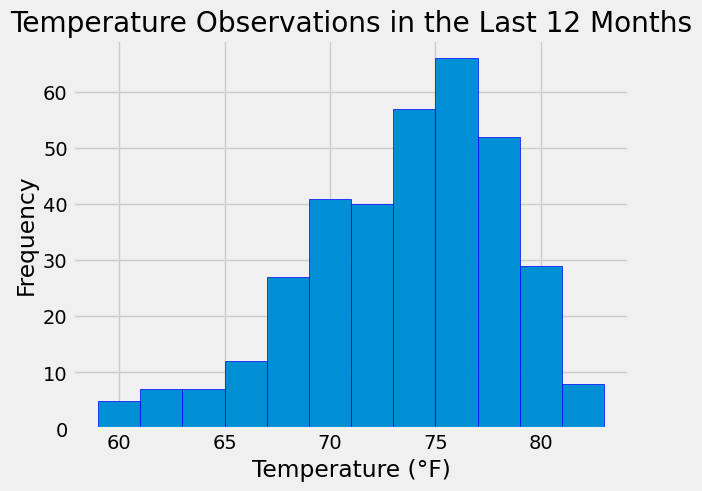

In [97]:
# Plot the results as a histogram
plt.hist(temperatures, bins=12, edgecolor='blue')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations in the Last 12 Months')
plt.show()


# Close Session

In [98]:
# Close Session
session.close()